# __Step 3.1b: dictionary vocab to get tf and tf-idf__

See notes in 3.1a also to get a sense what lead to the following analysis

7/8/22
- Did Tf, and the top terms are not particularly informative.

## ___Set up___

### Module import

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn import feature_extraction

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "3_key_term_temporal/3_1_pubmed_vocab"
work_dir.mkdir(parents=True, exist_ok=True)

os.chdir(work_dir)

# science dictionary vocab directory
sci_dict_dir = proj_dir / "_vocab"

# specify plant science corpus
corpus_dir  = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = corpus_dir / "corpus_plant_421658.tsv.gz"

# vecotrizer parameters
#max_features = 10000 # not relevant because vocab will be passed
ngram_range  = (1,3) 
max_df       = 0.8
min_df       = 0.001  # so at least ~400 articles
stop_words   = list(stopwords.words('english'))
lowercase    = True

# For tf-idf sparse matrix thresholding
col_sums_list_TI_min = 58.44802562279117

### Read corpus into dataframe and define X

In [4]:
corpus_df = pd.read_csv(corpus_file, sep='\t', compression='gzip')
corpus_df.shape

(421658, 11)

In [5]:
corpus_df.head(2)

,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,1
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,1


In [6]:
# corpus
X = corpus_df['txt']

### Get vocab list

In [7]:
# Get the dictionary file list
sci_dict_files = [i for i in sci_dict_dir.iterdir() \
                      if str(i).find(".items") != -1]
len(sci_dict_files)

11

In [8]:
# Go through files to generate a vocab dict
sci_dict_vocab = {}
for file in sci_dict_files:
  print(str(file).split("/")[-1])
  with open(file, "r+") as f:
    items = f.readlines()
    for item in items:
      item_proc = item.lower().strip()
      # Does not overlap with the terms in auto generated vocabs
      sci_dict_vocab[item_proc] = 1

vocab_bio.items
vocab_bmb.items
vocab_com.items
vocab_eco.items
vocab_evo.items
vocab_gen.items
vocab_go.items
vocab_mth.items
vocab_pln.items
vocab_po.items
vocab_sta.items


In [9]:
sci_dict_vocab_list = list(sci_dict_vocab.keys())
len(sci_dict_vocab_list)

224315

## ___Functions___

### Vectorization

In [10]:
def vectorize(vec_type, X, vocab):
  '''Intialize vectorizer, then fit and transform passed corpus
  Args:
    vec_type (str): tf or tfidf
    X (pandas series): the 'txt" column of the corpus
    vocab (list): vocabulary
  Return:
    X_vec (sparse matrix): vectorized X
    features (array): features in the vocab
  Output:
    X_vec: as pickle
    features: as pickle
  '''
  err = 0
  # Initialize vectorizer
  if vec_type == "tf":
    vec = feature_extraction.text.CountVectorizer(
            ngram_range  = ngram_range, stop_words   = stop_words,
            max_df       = max_df     , min_df       = min_df,
            vocabulary   = vocab      , lowercase    = lowercase)
  elif vec_type == "tfidf":
    vec = feature_extraction.text.TfidfVectorizer(
            ngram_range  = ngram_range, stop_words   = stop_words,
            max_df       = max_df     , min_df       = min_df,
            vocabulary   = vocab      , lowercase    = lowercase)
  else:
    print("ERR: unknown vectorizer type", vec_type)
  
  if not err:
    # vectorized X
    X_vec    = vec.fit_transform(X)
    # features
    features = vec.get_feature_names_out()
    # Output sparse matrix and features
    with open(work_dir / f'corpus_txt_{vec_type}_sparsematrix', 'wb') as f:
      pickle.dump(X_vec, f)
    with open(work_dir / f'corpus_txt_{vec_type}_features', 'wb') as f:
      pickle.dump(features, f)

    return X_vec, features
  

### Get column sum and mean values from sparse matrix

In [11]:
def get_col_sums_and_means(X_vec, vec_type):
  '''Get sum of row values for each column
  Args:
    X_vec (sparse array): vectorizer transformed X (texts)
    vec_type (str): tf or tfidf, for output names
  Return:
    
  Output:
    figure: distribution of tf-idf values for each column 
  '''

  # Get column sum
  col_sums = X_vec.sum(axis=0)

  # numbers of rows and columns
  (num_r, num_c) = X_vec.shape

  # col_sums is an Numpy Matrix, tried many way to get a list out of it like
  # ravel(), flatten(), but they don't work. So do it the old way.
  col_sums_list = []
  for i in tqdm(range(num_c)):
    col_sums_list.append(col_sums[0,i])

  # Get means
  col_means_list = [c_sum/num_r for c_sum in col_sums_list]

  fig, axes = plt.subplots(1, 2, figsize=(8,4))
  sns.histplot(col_sums_list, bins=100, log_scale=(False, True), ax=axes[0])
  axes[0].set_title("Sums of values in each column")
  sns.histplot(col_means_list, bins=100, log_scale=(False, True), ax=axes[1])
  axes[1].set_title("Means of values in each column")
  plt.savefig(work_dir / f"figure3_1_vocab_{vec_type}_dist.pdf")

  return col_sums_list, col_means_list

## ___Get matrix and features___

### Tf

In [12]:
X_vec_TF, features_TF = vectorize('tf', X, sci_dict_vocab_list)

100%|██████████| 224315/224315 [00:00<00:00, 1793083.59it/s]


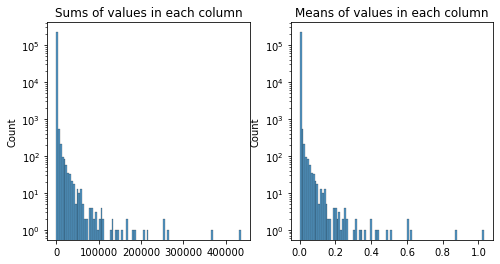

In [13]:
col_sums_TF, col_means_TF = get_col_sums_and_means(X_vec_TF, "tf")

In [14]:
feat_sum_TF = pd.DataFrame(list(zip(features_TF, col_sums_TF)), 
                           columns=["Features", "Tf sum"])

In [15]:
feat_sum_TF.head()

,Features,Tf sum
0,aav,22
1,a band,0
2,abc model,117
3,abdomen,126
4,abductor,0


In [16]:
feat_sum_TF.to_csv(work_dir / "table3_1_feat_sum_tf.tsv", sep='\t')

### Tf-idf

In [17]:
X_vec_TI, features_TI = vectorize('tfidf', X, sci_dict_vocab_list)
X_vec_TI.shape, len(features_TI)

((421658, 224315), 224315)

100%|██████████| 224315/224315 [00:00<00:00, 1554615.13it/s]


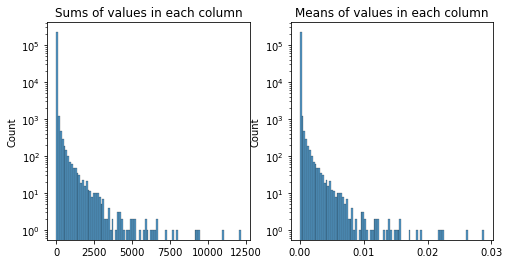

In [18]:
col_sums_TI, col_means_TI = get_col_sums_and_means(X_vec_TI, "tfidf")

In [19]:
feat_sum_TI = pd.DataFrame(list(zip(features_TI, col_sums_TI)), 
                           columns=["Features", "Tf-idf sum"])

In [20]:
feat_sum_TI.shape, type(feat_sum_TI), feat_sum_TI.head()

((224315, 2),
 pandas.core.frame.DataFrame,
     Features  Tf-idf sum
 0        aav    2.759074
 1     a band    0.000000
 2  abc model   16.556426
 3    abdomen   16.981512
 4   abductor    0.000000)

In [21]:
feat_sum_TI.to_csv(work_dir / "table3_1_feat_sum_tfidf.tsv", sep='\t')

### Filter columns based on Tf-idf of auto-generated vocab

See results in 3.1a:
- col_sums_list_TI_min=58.44802562279117
- See [this post for code](https://codereview.stackexchange.com/questions/138842/conditional-removal-of-columns-in-sparse-matrix), not working.
- See [this tutorial](https://cmdlinetips.com/2019/07/how-to-slice-rows-and-columns-of-sparse-matrix-in-python/).

In [22]:
# Create a numpy array using feat_sum_TI if it is above threshold
indices_above_threshold = []
for i in tqdm(range(len(feat_sum_TI))):
  if feat_sum_TI.iloc[i][1] >= col_sums_list_TI_min:
    indices_above_threshold.append(i)

print(len(indices_above_threshold))

100%|██████████| 224315/224315 [00:13<00:00, 16594.00it/s]

4542


In [23]:
# convert to numpy array
indices_above_threshold_array = np.array(indices_above_threshold)

# Get the sparse matrix columns based on indices
X_vec_TI_4542 = X_vec_TI[:, indices_above_threshold_array]
X_vec_TI_4542.shape

(421658, 4542)

In [24]:
# Modify feat_sum_TI dataframe to include only qualified features
feat_sum_TI_4642 = feat_sum_TI.iloc[indices_above_threshold]
feat_sum_TI_4642.shape

(4542, 2)

In [26]:
# Save sparse matrix to a pickle
with open(work_dir / f'tfidf_sparse_matrix_4542', 'wb') as f:
  pickle.dump(X_vec_TI_4542, f)

# Output feature names and tf-idf sum
feat_sum_TI_4642.to_csv(work_dir / f'tfidf_4542_feat_name_and_sum', 
                        sep='\t')